# trigger word detection
In this notebook we build a model for "trigger-word" or "wake-word" detection, using a deep RNN.

In [1]:
import numpy as np
import torch

from tqdm import tqdm
from torch import nn
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader

import os, sys
sys.path.append(os.sep.join(["..", "data"]))
from loaders.trigger_words import TriggerWords

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## # loading-datasets

In [2]:
train_dataset = TriggerWords(dataset_file='train.h5', dataset_size=4096)
test_dataset = TriggerWords(dataset_file='test.h5', dataset_size=256)

Data file found at ../data/trigger_words/train.h5! Loading data...


d:\Harsha\Documents\Projects\_machine-learning\3_sequence_models\..\data\loaders\trigger_words.py:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  self.__X = torch.Tensor(f['x'])


Data file found at ../data/trigger_words/test.h5! Loading data...


## # forward-propagation

> **Note**: for forward propagation equations, read Section-2 of [`.\backprop-gru.pdf`](./backprop-gru.pdf).

In [3]:
class TriggerWordDetector(nn.Module):
    def __init__(self):
        super(TriggerWordDetector, self).__init__()

        self.module_dict = nn.ModuleDict({
            'conv-1d-l1': nn.utils.skip_init(nn.Conv1d,
                in_channels=101, # C_in
                out_channels=196, # C_out
                kernel_size=15,
                stride=4,
                padding=0,
                bias=True),
            'batch-norm-l1': nn.BatchNorm1d(
                num_features=196),
            'activation-l1': nn.ReLU(),
            'dropout-l1': nn.Dropout(p=0.8),

            'gru-l2': nn.GRU(
                input_size=196,
                hidden_size=128, # a_out
                num_layers=1,
                bias=True,
                batch_first=True,
                dropout=0.0),
            'dropout-l2': nn.Dropout(
                p=0.8),
            'batch-norm-l2': nn.BatchNorm1d(
                num_features=128),
            
            'gru-l3': nn.GRU(
                input_size=128, # a_out
                hidden_size=128, # a_out
                num_layers=1,
                bias=True,
                batch_first=True,
                dropout=0.0),
            'dropout-l3-1': nn.Dropout(
                p=0.8),
            'batch-norm-l3': nn.BatchNorm1d(
                num_features=128),
            'dropout-l3-2': nn.Dropout(
                p=0.8),

            'linear-l4': nn.utils.skip_init(nn.Linear,
                in_features=128, # a_out
                out_features=1, # n_y
                bias=True),
            'activation-l4': nn.Sigmoid()
        })
        nn.init.xavier_uniform_(tensor=self.module_dict['conv-1d-l1'].weight)
        nn.init.zeros_(tensor=self.module_dict['conv-1d-l1'].bias)
        nn.init.xavier_uniform_(tensor=self.module_dict['linear-l4'].weight)
        nn.init.zeros_(tensor=self.module_dict['linear-l4'].bias)

    def forward(self, x: torch.Tensor):
        """
        x: shape -> (m,C_in,T_x); where, C_in - is the number of channels
        """

        # shape -> (m, C_out, T_y)
        x = self.module_dict['conv-1d-l1'](x)
        # shape -> (m, C_out, T_y)
        x = self.module_dict['batch-norm-l1'](x)
        # shape -> (m, C_out, T_y)
        x = self.module_dict['activation-l1'](x)
        # shape -> (m, C_out, T_y)
        x = self.module_dict['dropout-l1'](x)

        # shape -> (m, T_y, C_out)
        # permute so that the dimension align for RNN
        x = torch.permute(input=x, dims=(0,2,1))
        a_0 = torch.zeros(size=(1, x.shape[0], 128), device=device)
        # shape -> (m, T_y, a_out)
        x, _ = self.module_dict['gru-l2'](x, a_0)
        # shape -> (m, T_y, a_out)
        x = self.module_dict['dropout-l2'](x)
        # shape -> (m, a_out, T_y)
        # permute so that the dimensions align for batch-norm
        x = torch.permute(input=x, dims=(0,2,1))
        # shape -> (m, a_out, T_y)
        x = self.module_dict['batch-norm-l2'](x)
    
        # shape -> (m, T_y, a_out)
        # permute so that the dimension align for RNN
        x = torch.permute(input=x, dims=(0,2,1))
        a_0 = torch.zeros(size=(1, x.shape[0], 128), device=device)
        # shape -> (m, T_y, a_out)
        x, _ = self.module_dict['gru-l3'](x, a_0)
        # shape -> (m, T_y, a_out)
        x = self.module_dict['dropout-l3-1'](x)
        # shape -> (m, a_out, T_y)
        # permute so that the dimensions align for batch-norm
        x = torch.permute(input=x, dims=(0,2,1))
        # shape -> (m, a_out, T_y)
        x = self.module_dict['batch-norm-l3'](x)
        # shape -> (m, a_out, T_y)
        x = self.module_dict['dropout-l3-2'](x)

        # shape -> (m, T_y, a_out)
        # permute so that the dimensions align for linear
        x = torch.permute(input=x, dims=(0,2,1))
        # shape -> (m, T_y, n_y)
        x = self.module_dict['linear-l4'](x)
        # shape -> (m, T_y, n_y)
        x = self.module_dict['activation-l4'](x)

        return torch.squeeze(x)

In [4]:
model = TriggerWordDetector()
model.to(device=device)
print(model)

TriggerWordDetector(
  (module_dict): ModuleDict(
    (conv-1d-l1): Conv1d(101, 196, kernel_size=(15,), stride=(4,))
    (batch-norm-l1): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation-l1): ReLU()
    (dropout-l1): Dropout(p=0.8, inplace=False)
    (gru-l2): GRU(196, 128, batch_first=True)
    (dropout-l2): Dropout(p=0.8, inplace=False)
    (batch-norm-l2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gru-l3): GRU(128, 128, batch_first=True)
    (dropout-l3-1): Dropout(p=0.8, inplace=False)
    (batch-norm-l3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout-l3-2): Dropout(p=0.8, inplace=False)
    (linear-l4): Linear(in_features=128, out_features=1, bias=True)
    (activation-l4): Sigmoid()
  )
)


## # backward-propagation

> **Note**: for backward-propagation equations, read Section-3 of [`.\backprop-gru.pdf`](./backprop-gru.pdf).

In [5]:
def evaluate_model(model: nn.Module, loss_func: nn.Module, test_data: Dataset, 
        batch_size: int, classify_threshold: np.float32):
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
    
    total_test_loss: float = 0
    test_correct_count: int = 0
    
    with torch.no_grad():
        model.eval() # set model in evaluation mode

        for batch, (Xb, Yb) in enumerate(test_loader):
            # movie them to CUDA if device == 'cuda'
            Xb, Yb = Xb.to(device=device), Yb.to(device=device)

            pred = model(Xb)
            loss = loss_func(pred, Yb)

            total_test_loss += loss.item() * len(Xb)
            test_correct_count += (torch.where(pred >= classify_threshold, 1, 0) == Yb)\
                .sum().item() / Yb.shape[1] # divide by T_y to get avg. per example
    
    return total_test_loss / len(test_data), test_correct_count / len(test_data)

def visualize_training(train_accuracies: list, train_losses: list, 
        test_accuracies: list, test_losses: list):
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(30,15))

    ax1 = axs[0]
    ax1.plot(np.array(train_accuracies) * 100, label="train-accuracy")
    ax1.plot(np.array(test_accuracies) * 100, label="test-accuracy")
    ax1.set_ylabel('accuracy -->')
    ax1.set_xlabel('epoch -->')
    ax1.legend()

    ax2 = axs[1]
    ax2.plot(train_losses, label="train-loss")
    ax2.plot(test_losses, label="test-loss")
    ax2.set_ylabel('loss -->')
    ax2.set_xlabel('epoch -->')
    ax2.legend()

    plt.show()

def learn_model(train_data: Dataset, test_data: Dataset, model: nn.Module,
        learning_rate: np.double, beta1: np.double, beta2: np.double, 
        epsilon: np.double, num_epochs: int, batch_size: int, 
        lr_decay_rate: np.float32, classify_threshold: np.float32):
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    loss_func = nn.BCELoss(reduction='mean') # compute the mean of the loss
    optimizer = torch.optim.Adam(params=model.parameters(), 
        lr=learning_rate, betas=[beta1, beta2], eps=epsilon)
    lr_schedular = torch.optim.lr_scheduler.LambdaLR(
        optimizer=optimizer, lr_lambda=lambda epoch: learning_rate / (1 + lr_decay_rate * epoch))
  
    train_losses = list()
    train_accuracies = list()
    test_losses = list()
    test_accuracies = list()

    for e in tqdm(np.arange(start=0, stop=num_epochs, step=1)):
        epochal_train_loss: float = 0.0
        epochal_correct_count: int = 0

        model.train(mode=True)
        for batch, (Xb, Yb) in enumerate(train_loader):
            # move them to CUDA/CPU device
            Xb, Yb = Xb.to(device=device), Yb.to(device=device)

            pred = model(Xb)
            loss = loss_func(pred, Yb) 

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # for debugging
            epochal_train_loss += loss.item() * len(Xb)
            epochal_correct_count += ( # divide by T_y, to get avg. per example
                torch.where(pred >= classify_threshold, 1, 0) == Yb)\
                    .sum().item() / Yb.shape[1]

        train_losses.append(epochal_train_loss / len(train_data))
        train_accuracies.append(epochal_correct_count / len(train_data))

        test_loss, test_accuracy = evaluate_model(
            model=model, test_data=test_data, loss_func=loss_func, 
            batch_size=batch_size, classify_threshold=classify_threshold)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # updating learning rate
        lr_schedular.step()

    return model, train_losses,\
        train_accuracies, test_losses, test_accuracies

## # training-model

> **Note**: due to lack of adequate computational resources, this model was trained on a train-dataset of size 2000, with a test-dataset of size 200, and for 300 epochs. Training with a dataset-size of around ~4000 examples and for around ~900 epochs **could** yield useful results.

100%|██████████| 300/300 [1:59:18<00:00, 23.86s/it]


Test Error: 
 Accuracy: 69.8%, Avg loss: 0.750459 



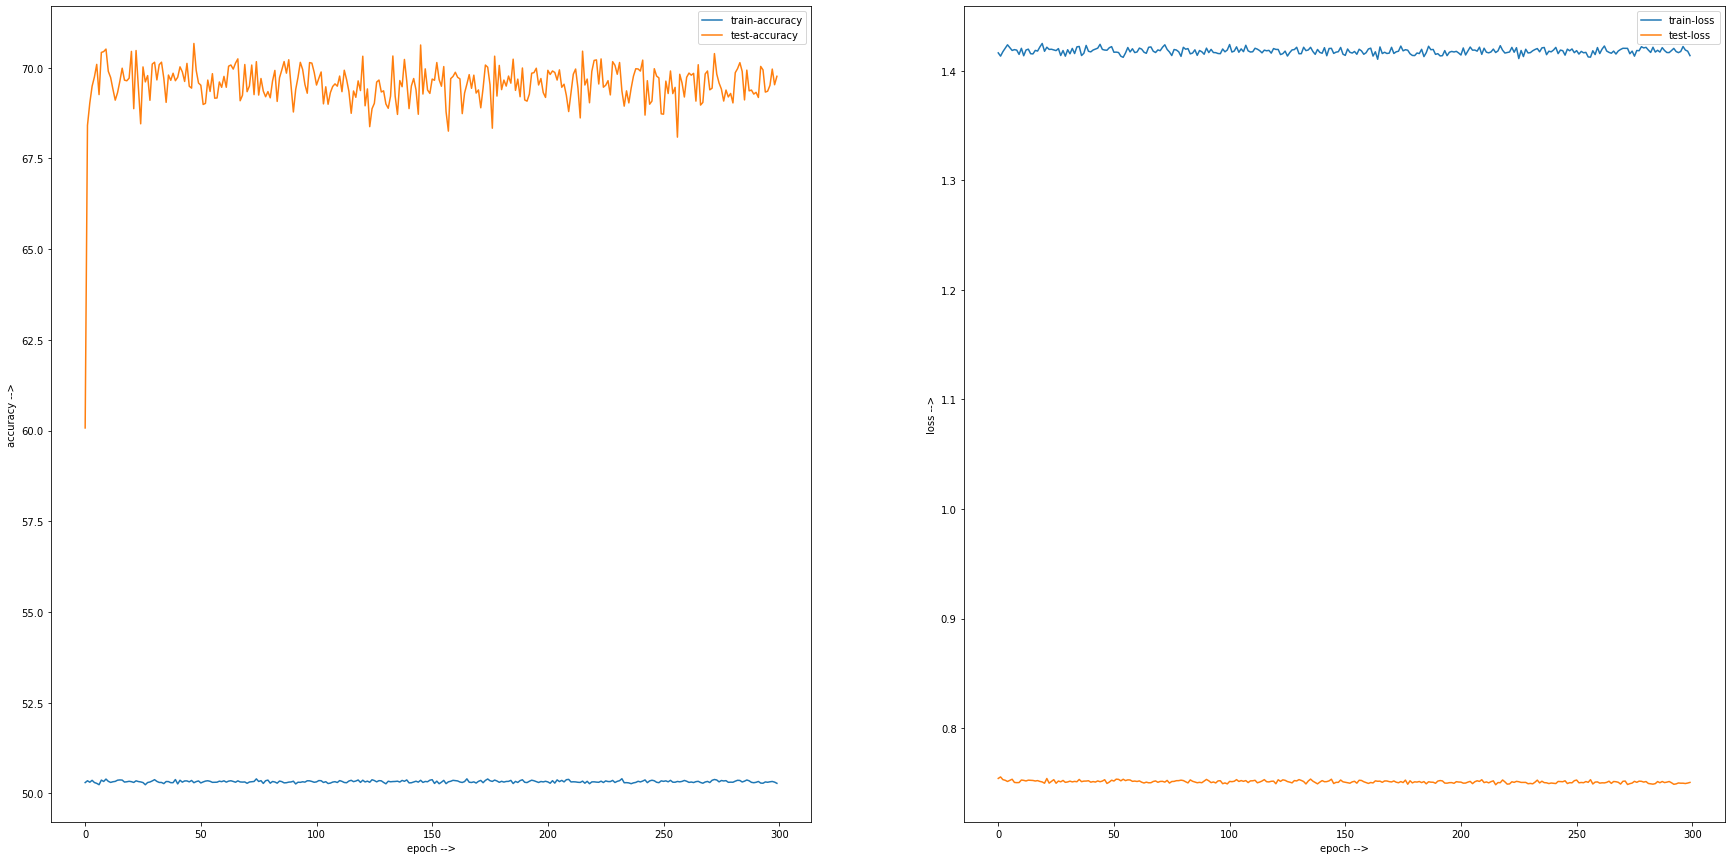

In [6]:
model, train_losses, train_accuracies, test_losses, test_accuracies = learn_model(
    train_data=train_dataset, test_data=test_dataset, model=model, 
    learning_rate=1e-4, beta1=0.9, beta2=0.999, epsilon=1e-08, 
    num_epochs=300, batch_size=64, classify_threshold=0.5, lr_decay_rate=0.01)

test_loss, test_accuracy = evaluate_model(model=model, test_data=test_dataset, 
    batch_size=64, loss_func=nn.BCELoss(reduction='mean'), classify_threshold=0.5)
print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

visualize_training(train_accuracies=train_accuracies, train_losses=train_losses,
    test_accuracies=test_accuracies, test_losses=test_losses)